In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn import metrics
from category_encoders import TargetEncoder

In [3]:
log_shots = pd.read_csv('shot_logs.csv')

In [4]:
log_shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [5]:
# Convert GAME_CLOCK from 'MM:SS' to total seconds
def convert_game_clock_to_seconds(clock_str):
    if isinstance(clock_str, str):
        parts = clock_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
    return np.nan

log_shots['GAME_CLOCK_SECONDS'] = log_shots['GAME_CLOCK'].apply(convert_game_clock_to_seconds)
log_shots[['GAME_CLOCK', 'GAME_CLOCK_SECONDS']].head()
log_shots.drop(columns=['GAME_CLOCK'], inplace=True)
log_shots = log_shots.dropna(how = 'any', axis = 0)


In [6]:
log_shots.loc[log_shots['LOCATION'] == 'H', 'LOCATION'] = 1
log_shots.loc[log_shots['LOCATION'] == 'A', 'LOCATION'] = 0
log_shots['LOCATION'] = log_shots['LOCATION'].astype('int32')

log_shots.loc[log_shots['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = 1
log_shots.loc[log_shots['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = 0
log_shots['SHOT_RESULT'] = log_shots['SHOT_RESULT'].astype('int32')


In [7]:
#Checking the correlation between numerical features
numerical_col = log_shots.select_dtypes(include = ['float64', 'int64','int32'])
corr = numerical_col.corr()
corr
#add a heat map in here

,GAME_ID,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,GAME_CLOCK_SECONDS
GAME_ID,1.000000,-0.004312,0.001160,0.010216,-0.005042,0.014530,0.001411,-0.001503,0.000774,0.004281,-0.009302,0.028307,0.007397,-0.009302,-0.008719,0.028431,0.001076
LOCATION,-0.004312,1.000000,0.160892,-0.003052,0.002915,0.008083,-0.014326,-0.012082,-0.000946,0.006286,0.008726,-0.005938,0.003746,0.008726,0.010051,0.010240,-0.000110
FINAL_MARGIN,0.001160,0.160892,1.000000,0.004753,0.001812,-0.009276,0.010109,0.009231,0.010601,0.026976,0.058249,0.057017,0.033929,0.058249,0.064363,-0.050164,0.001195
SHOT_NUMBER,0.010216,-0.003052,0.004753,1.000000,0.654080,-0.032683,0.144983,0.150743,0.005547,-0.005675,-0.006589,0.013745,-0.037538,-0.006589,-0.008612,-0.008223,-0.232635
PERIOD,-0.005042,0.002915,0.001812,0.654080,1.000000,-0.051796,0.062193,0.052911,0.029559,0.046028,-0.015078,0.013115,-0.009665,-0.015078,-0.009728,0.003866,-0.022991
SHOT_CLOCK,0.014530,0.008083,-0.009276,-0.032683,-0.051796,1.000000,-0.082771,-0.147688,-0.173026,-0.032809,0.096855,-0.003289,0.026558,0.096855,0.084173,0.038315,0.021242
DRIBBLES,0.001411,-0.014326,0.010109,0.144983,0.062193,-0.082771,1.000000,0.922755,-0.088753,-0.175090,-0.033922,0.016859,-0.155250,-0.033922,-0.056115,0.025620,-0.105242
TOUCH_TIME,-0.001503,-0.012082,0.009231,0.150743,0.052911,-0.147688,0.922755,1.000000,-0.089196,-0.187165,-0.047230,0.016278,-0.167290,-0.047230,-0.069758,0.002687,-0.098366
SHOT_DIST,0.000774,-0.000946,0.010601,0.005547,0.029559,-0.173026,-0.088753,-0.089196,1.000000,0.736470,-0.183711,0.002281,0.532083,-0.183711,-0.060004,-0.025378,0.001512
PTS_TYPE,0.004281,0.006286,0.026976,-0.005675,0.046028,-0.032809,-0.175090,-0.187165,0.736470,1.000000,-0.113273,0.005649,0.417863,-0.113273,0.039781,0.010640,-0.026627


In [8]:
# Select only the specified features for modeling
selected_features = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_SECONDS', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'CLOSEST_DEFENDER', 'player_name']
log_shots_selected = log_shots[selected_features]
log_shots_selected.head()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_SECONDS,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,CLOSEST_DEFENDER,player_name
0,0,1,1,69,10.8,2,1.9,7.7,2,1.3,"Anderson, Alan",brian roberts
1,0,2,1,14,3.4,0,0.8,28.2,3,6.1,"Bogdanovic, Bojan",brian roberts
3,0,4,2,707,10.3,2,1.9,17.2,2,3.4,"Brown, Markel",brian roberts
4,0,5,2,634,10.9,2,2.7,3.7,2,1.1,"Young, Thaddeus",brian roberts
5,0,6,2,495,9.1,2,4.4,18.4,2,2.6,"Williams, Deron",brian roberts


In [9]:
X = log_shots_selected[selected_features]
X.head()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_SECONDS,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,CLOSEST_DEFENDER,player_name
0,0,1,1,69,10.8,2,1.9,7.7,2,1.3,"Anderson, Alan",brian roberts
1,0,2,1,14,3.4,0,0.8,28.2,3,6.1,"Bogdanovic, Bojan",brian roberts
3,0,4,2,707,10.3,2,1.9,17.2,2,3.4,"Brown, Markel",brian roberts
4,0,5,2,634,10.9,2,2.7,3.7,2,1.1,"Young, Thaddeus",brian roberts
5,0,6,2,495,9.1,2,4.4,18.4,2,2.6,"Williams, Deron",brian roberts


In [10]:
Y = log_shots['SHOT_RESULT']
Y.head()

0    1
1    0
3    0
4    0
5    0
Name: SHOT_RESULT, dtype: int32

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.2,
                                                    random_state = 33)

In [12]:
X_train.dtypes
X_train.head()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_SECONDS,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,CLOSEST_DEFENDER,player_name
42934,0,3,2,486,20.9,2,4.3,3.2,2,0.8,"Evans, Reggie",elfrid payton
68355,0,8,4,652,17.8,2,2.0,2.7,2,2.9,"Fredette, Jimmer",isaiah thomas
127283,0,4,4,575,13.0,0,0.6,23.4,3,8.4,"Hairston, PJ",bojan bogdanovic
31418,1,5,2,318,24.0,0,0.0,2.3,2,2.9,"Mayo, O.J.",kyle lowry
122432,0,3,2,606,10.6,1,1.2,14.1,2,3.2,"Iguodala, Andre",shabazz muhammad


In [13]:
#target encoding for categorical features
categorical_features = ['CLOSEST_DEFENDER','player_name']
encoder = TargetEncoder(
    cols=categorical_features,
    smoothing=0.2 # İyi bir başlangıç değeridir.
)
encoder.fit(X_train, Y_train)

,verbose,0
,cols,"['CLOSEST_DEFENDER', 'player_name']"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20
,smoothing,0.2
,hierarchy,None


In [14]:
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [15]:
import xgboost as xgb
from sklearn import metrics
# Changing the format
dtest = xgb.DMatrix(X_test)
d_train_xgboost = xgb.DMatrix(X_train,label = Y_train)

# Parameter of boosting
parameters = {
    # Hız ve CPU Kullanımı
    'n_jobs': -1,                 # Tüm işlemci çekirdeklerini kullanır
    'tree_method': 'hist',        # Hızlı eğitim algoritması

    # Model Karmaşıklığı ve Öğrenme
    'objective': 'binary:logistic',
    'eval_metric': 'auc',         # Binary Classification için iyi bir performans metriği
    'max_depth': 10,              # Yüksek karmaşıklık
    'learning_rate': 0.05,        # Stabil öğrenme hızı
    'min_child_weight': 0.5,      # Daha ince detaylara izin verir

    # Güçlü Düzenleme (Aşırı Öğrenmeyi Engelleme)
    'lambda': 5,                  # Yüksek L2 Regularizasyonu
    'alpha': 0.5,                 # L1 Regularizasyonu ekleme
    'gamma': 0.5,                 # Yüksek bölünme zorluğu
    'subsample': 0.7,             # Örneklemeyi rastgeleleştirme
    'colsample_bytree': 0.7       # Özellik seçimini rastgeleleştirme
}

plst = list(parameters.items())

In [16]:
# Training model
xgb_model = xgb.train(parameters, d_train_xgboost, 50)

In [17]:
y_pred_xgb = xgb_model.predict(dtest)
y_pred_xgb

array([0.34517118, 0.65802115, 0.6936154 , ..., 0.3589797 , 0.44028702,
       0.60904664], shape=(24501,), dtype=float32)

In [18]:
# We here will assign values of y_pred_xgb to three values(0.5,1,0) because we do not want too many decimals and less distinct values will help us to predict.
for i in range(0, X_test.shape[0]): 
    if y_pred_xgb[i]>=.5:       # setting threshold to .5 
       y_pred_xgb[i]=1 
    else: 
       y_pred_xgb[i]=0  

In [19]:
print ("Accuracy with XGBoost= ", metrics.accuracy_score(y_pred_xgb, Y_test))


Accuracy with XGBoost=  0.6198114362679075


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

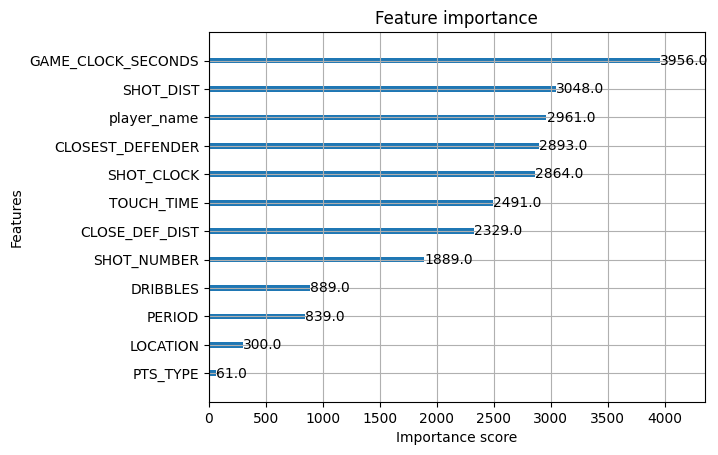

In [20]:
xgb.plot_importance(xgb_model)


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score # AUC kontrolü için
import statsmodels.api as sm # Q-Q plot için

1. ERROR ANALYSIS (RESIDUAL ANALYSIS)

Model Performance Metrics:
Log Loss: 6.0611
AUC-ROC Score: 0.5992


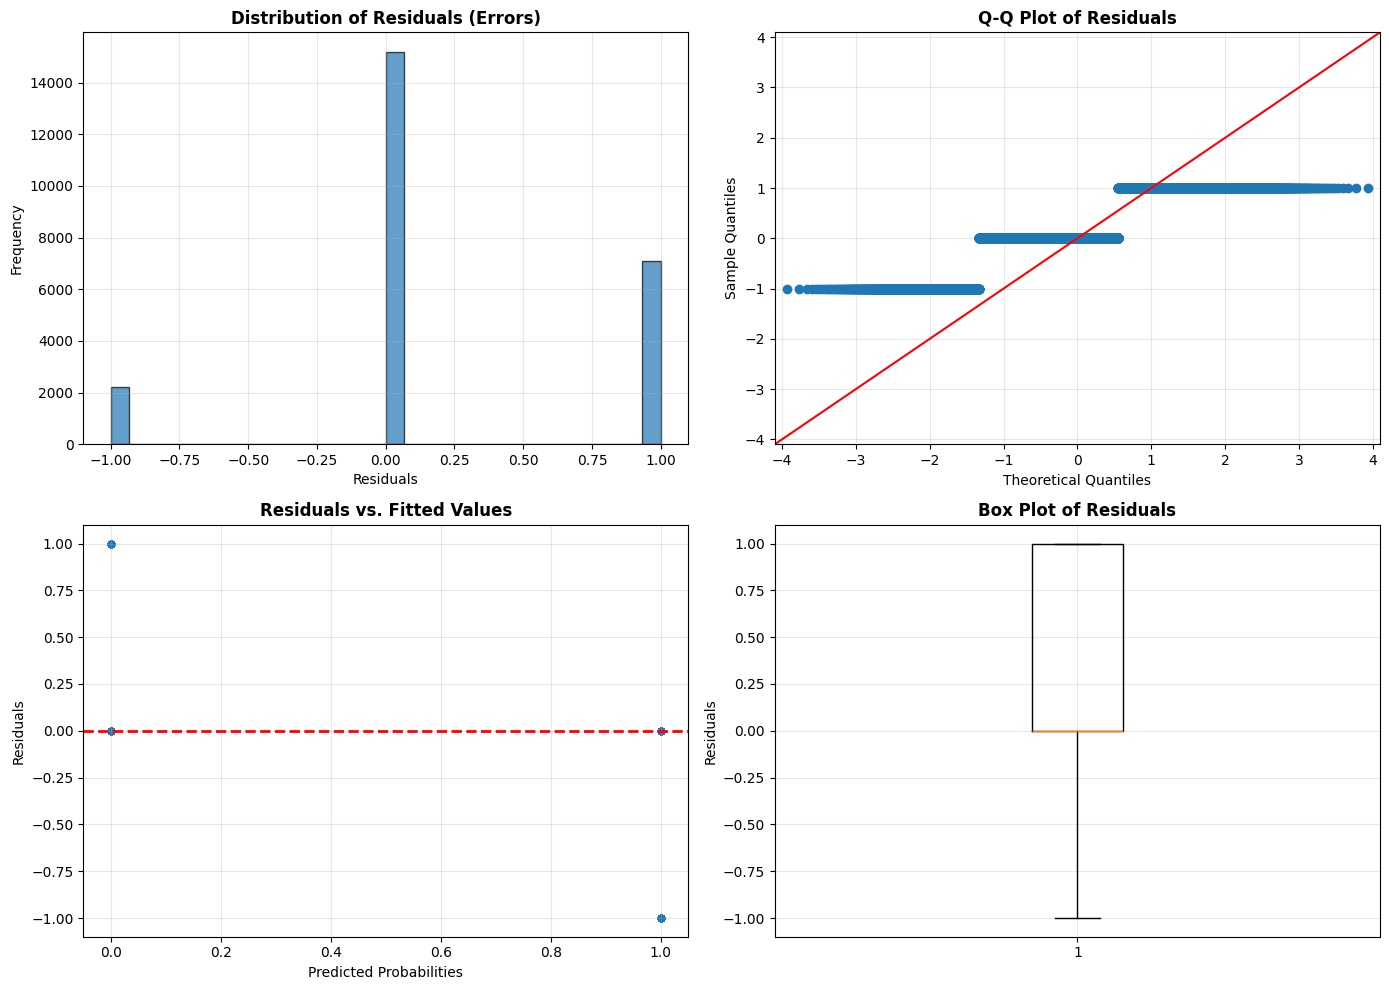


Shapiro-Wilk Test on Residuals:
Test Statistic: 0.748115
P-value: 5.026703e-66
Conclusion: Residuals are NOT normally distributed (p < 0.05)

2. MULTIVARIATE NORMALITY CHECK (UNIVARIATE PROXY)

SHOT_DIST:
  Shapiro-Wilk Test Statistic: 0.897714
  P-value: 1.365182e-49
  Conclusion: SHOT_DIST is NOT normally distributed (p < 0.05) ✗

CLOSE_DEF_DIST:
  Shapiro-Wilk Test Statistic: 0.883546
  P-value: 8.291984e-52
  Conclusion: CLOSE_DEF_DIST is NOT normally distributed (p < 0.05) ✗

SHOT_CLOCK:
  Shapiro-Wilk Test Statistic: 0.985833
  P-value: 5.287236e-22
  Conclusion: SHOT_CLOCK is NOT normally distributed (p < 0.05) ✗

DRIBBLES:
  Shapiro-Wilk Test Statistic: 0.634971
  P-value: 1.708686e-73
  Conclusion: DRIBBLES is NOT normally distributed (p < 0.05) ✗

TOUCH_TIME:
  Shapiro-Wilk Test Statistic: 0.752044
  P-value: 1.020105e-65
  Conclusion: TOUCH_TIME is NOT normally distributed (p < 0.05) ✗


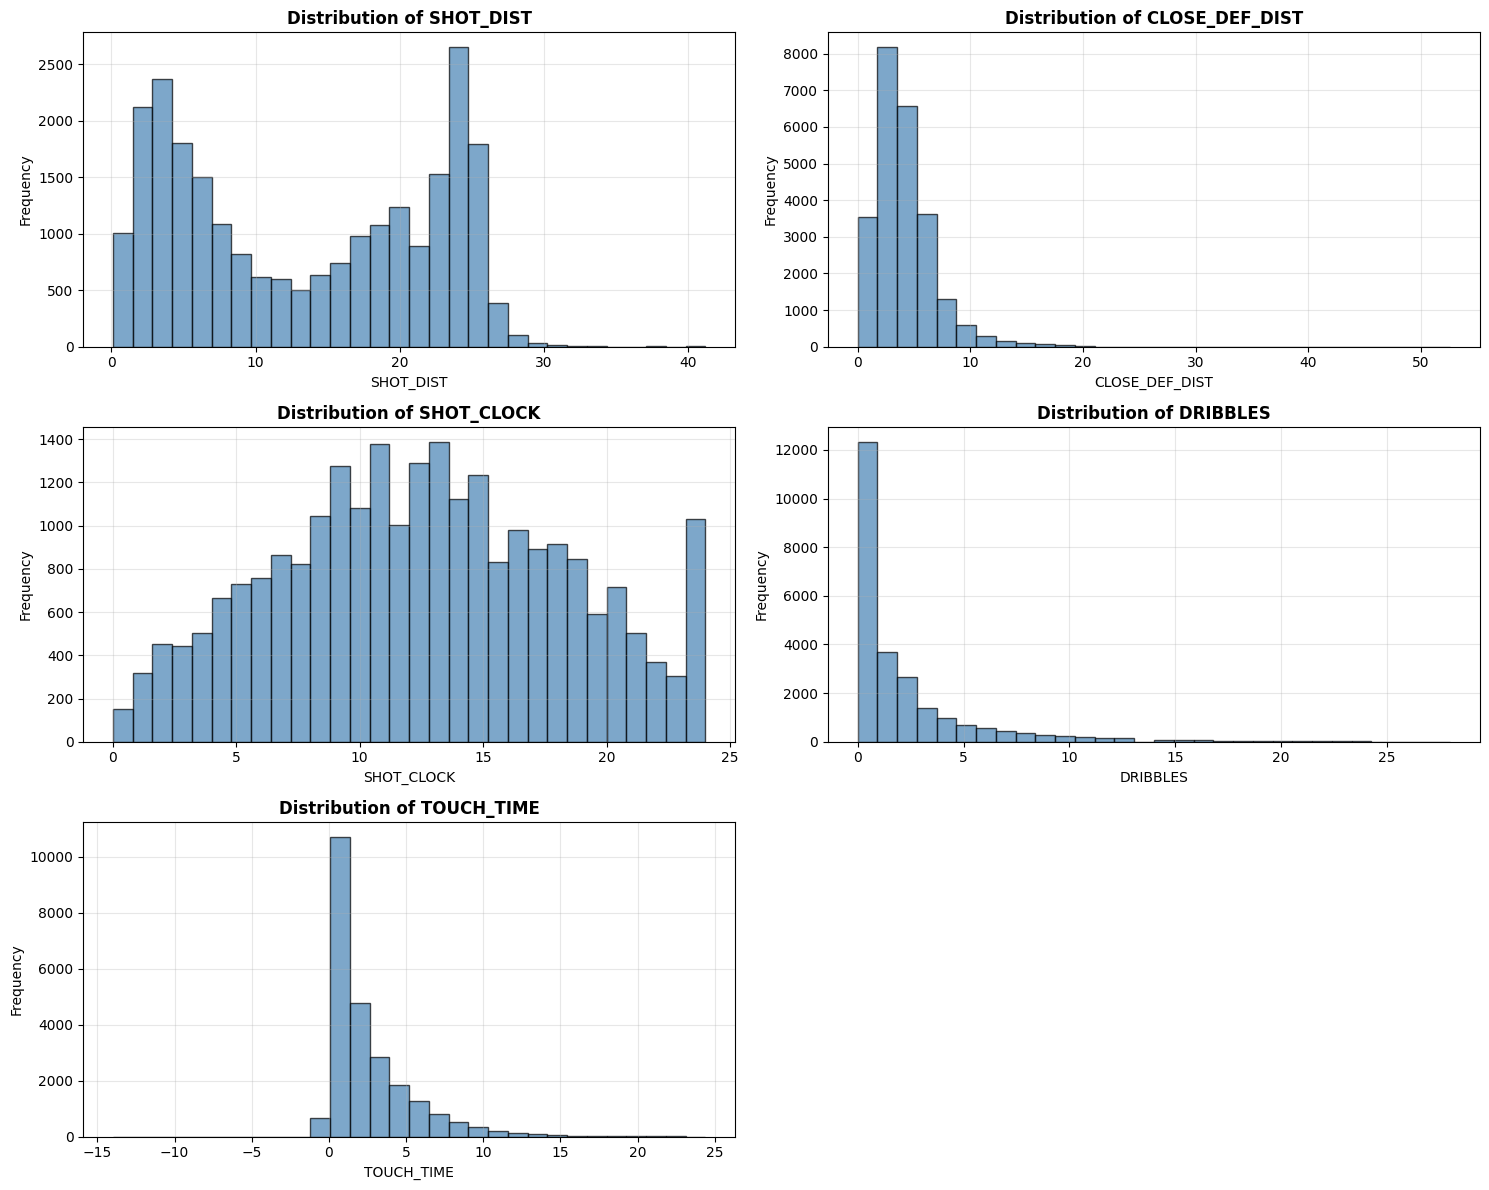


STATISTICAL ASSUMPTION CHECKS COMPLETED


In [24]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. ERROR ANALYSIS (RESIDUAL ANALYSIS)
# ============================================================================

# Calculate residuals (errors)
residuals = Y_test.values - y_pred_xgb

print("="*70)
print("1. ERROR ANALYSIS (RESIDUAL ANALYSIS)")
print("="*70)

# Calculate performance metrics
log_loss = metrics.log_loss(Y_test, y_pred_xgb)
auc_roc = metrics.roc_auc_score(Y_test, y_pred_xgb)

print(f"\nModel Performance Metrics:")
print(f"Log Loss: {log_loss:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

# 1.1 Histogram of Residuals with KDE
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram with KDE
axes[0, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Residuals (Errors)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residuals')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 1.2 Q-Q Plot for Normality Check
sm.qqplot(residuals, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 1.3 Residuals vs. Fitted Values (Homoscedasticity Check)
axes[1, 0].scatter(y_pred_xgb, residuals, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuals vs. Fitted Values', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Probabilities')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 1.4 Residuals Distribution Box Plot
axes[1, 1].boxplot(residuals, vert=True)
axes[1, 1].set_title('Box Plot of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Perform Shapiro-Wilk test on residuals
residuals_sample = residuals[:5000] if len(residuals) > 5000 else residuals
shapiro_stat, shapiro_p = stats.shapiro(residuals_sample)
print(f"\nShapiro-Wilk Test on Residuals:")
print(f"Test Statistic: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.6e}")
if shapiro_p > 0.05:
    print(f"Conclusion: Residuals are normally distributed (p > 0.05)")
else:
    print(f"Conclusion: Residuals are NOT normally distributed (p < 0.05)")

# ============================================================================
# 2. MULTIVARIATE NORMALITY CHECK (UNIVARIATE PROXY)
# ============================================================================

print("\n" + "="*70)
print("2. MULTIVARIATE NORMALITY CHECK (UNIVARIATE PROXY)")
print("="*70)

# Define continuous features to check
continuous_features = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME']

# Create subplots for each feature
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    # Histogram with KDE
    axes[idx].hist(X_test[feature], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)
    
    # Perform Shapiro-Wilk test
    feature_sample = X_test[feature].dropna().values[:5000]
    shapiro_stat, shapiro_p = stats.shapiro(feature_sample)
    
    print(f"\n{feature}:")
    print(f"  Shapiro-Wilk Test Statistic: {shapiro_stat:.6f}")
    print(f"  P-value: {shapiro_p:.6e}")
    if shapiro_p > 0.05:
        print(f"  Conclusion: {feature} is normally distributed (p > 0.05) ✓")
    else:
        print(f"  Conclusion: {feature} is NOT normally distributed (p < 0.05) ✗")

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("STATISTICAL ASSUMPTION CHECKS COMPLETED")
print("="*70)